In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/landcover_miniproject3/dataset

/content/drive/MyDrive/landcover_miniproject3/dataset


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [4]:
# Direktori dataset
train_dir = "/content/drive/MyDrive/landcover_miniproject3/dataset/train"
valid_dir = "/content/drive/MyDrive/landcover_miniproject3/dataset/valid"
test_dir = "/content/drive/MyDrive/landcover_miniproject3/dataset/test"

In [5]:
# Parameter preprocessing
IMG_SIZE = (256, 256)  # Resize ke 256x256


In [6]:
# Mapping warna ke kelas
COLOR_MAP = {
    (96, 230, 99): 0,  # hutan_lahan_kering_primer
    (114, 255, 0): 1,  # hutan_lahan_kering_sekunder
    (229, 210, 152): 2,  # perkebunan
    (235, 192, 167): 3,  # semak_belukar
    (211, 229, 152): 4,  # hutan_tanaman
    (0, 0, 0): 5,  # pemukiman
    (214, 0, 115): 6,  # tanah_terbuka
    (212, 252, 247): 7,  # tubuh_air
    (255, 127, 127): 8,  # semak_belukar_rawa
    (246, 254, 167): 9,  # pertanian_lahan_kering
    (237, 245, 0): 10,  # pertanian_lahan_kering_campursemak
    (168, 214, 255): 11,  # sawah
    (202, 122, 245): 12,  # bandara/pelabuhan
    (114, 142, 167): 13,  # transmigrasi
    (167, 4, 0): 14  # pertambangan
}

In [7]:
def rgb_to_label(mask):
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for rgb, label in COLOR_MAP.items():
        mask_match = np.all(mask == np.array(rgb), axis=-1)
        label_mask[mask_match] = label
    return label_mask
# Fungsi untuk memuat gambar dan mask multi-kelas
def load_data(image_dir, mask_dir=None):
    images = []
    masks = [] if mask_dir else None

    for filename in os.listdir(image_dir):
        if "_sat.jpg" in filename:
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0  # Normalisasi
            images.append(img)

            if mask_dir:
                mask_filename = filename.replace("_sat.jpg", "_mask.jpg")
                mask_path = os.path.join(mask_dir, mask_filename)
                if os.path.exists(mask_path):
                    mask = load_img(mask_path, target_size=IMG_SIZE)
                    mask = img_to_array(mask).astype(np.uint8)
                    mask = rgb_to_label(mask)  # Konversi ke indeks kelas
                    masks.append(mask)

    images = np.array(images)
    masks = np.array(masks) if masks is not None else None
    if masks is not None:
        masks = masks[..., np.newaxis]  # Tambahkan dimensi channel

    return images, masks

In [8]:
# Load dataset
X_train, Y_train = load_data(train_dir, train_dir)
X_valid, Y_valid = load_data(valid_dir, valid_dir)
X_test, _ = load_data(test_dir)  # Tidak ada mask di test


In [9]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape

((123, 256, 256, 3),
 (123, 256, 256, 1),
 (35, 256, 256, 3),
 (35, 256, 256, 1),
 (18, 256, 256, 3))

In [10]:
#import model

from tensorflow.keras.models import load_model

# Tentukan path model yang telah disimpan
model_path = '/content/drive/MyDrive/landcover_miniproject3/model/unet/model_best_unet_100.h5'

# Memuat model dari file .h5
model_loaded = load_model(model_path)

# Sekarang model sudah siap digunakan untuk prediksi atau melanjutkan pelatihan


**IOU**

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt



def calculate_iou_metrics(model, x_data, y_data, num_classes=15):
    """
    Menghitung IoU metrics dari model segmentasi land cover

    Parameters:
        model: Model Keras yang sudah dilatih
        x_data: Data input gambar
        y_data: Data ground truth label (dengan format [..., 1])
        num_classes: Jumlah kelas dalam segmentasi

    Returns:
        Dictionary berisi mean_iou dan iou_per_class
    """
    # Prediksi model
    y_pred = model.predict(x_data)

    # Mengonversi prediksi ke indeks kelas
    if len(y_pred.shape) == 4 and y_pred.shape[-1] > 1:  # Output model adalah one-hot encoding
        y_pred = np.argmax(y_pred, axis=-1)

    # Mengonversi y_true ke format yang tepat
    y_true = np.squeeze(y_data)  # Menghilangkan dimensi channel terakhir

    # 1. Menggunakan metrik Keras MeanIoU
    m = MeanIoU(num_classes=num_classes)
    m.update_state(y_true, y_pred)
    mean_iou_keras = m.result().numpy()

    # 2. Menghitung IoU per kelas secara manual
    class_iou = []
    class_names = ["hutan_lahan_kering_primer", "hutan_lahan_kering_sekunder", "perkebunan", "semak_belukar", "hutan_tanaman", "pemukiman", "tanah_terbuka", "tubuh_air", "semak_belukar_rawa", "perkebunan_lahan_kering", "perkebunan_lahan_kering_campursemak","sawah", "bandara/pelabuhan", "transmigrasi", "pertambangan"]

    for class_id in range(num_classes):
        # Menghitung IoU untuk setiap kelas secara manual
        true_class = (y_true == class_id).astype(np.int32)
        pred_class = (y_pred == class_id).astype(np.int32)

        # True Positive (TP)
        tp = np.sum(true_class * pred_class)
        # False Positive (FP)
        fp = np.sum(pred_class) - tp
        # False Negative (FN)
        fn = np.sum(true_class) - tp

        # IoU = TP / (TP + FP + FN)
        if tp + fp + fn > 0:
            iou = tp / (tp + fp + fn)
        else:
            iou = 0.0

        class_iou.append(iou)

    # Menghitung mean IoU dari semua kelas
    mean_iou_manual = np.mean(class_iou)

    # Membuat hasil dalam format yang mudah dibaca
    results = {
        "mean_iou_keras": mean_iou_keras,
        "mean_iou_manual": mean_iou_manual,
        "class_iou": {class_names[i]: class_iou[i] for i in range(num_classes)},
        "class_iou_values": class_iou
    }

    return results

def print_iou_results(model, X_valid, Y_valid, num_classes=15):
    """
    Mencetak hasil evaluasi IoU dengan format yang rapi
    """
    results = calculate_iou_metrics(model, X_valid, Y_valid, num_classes)

    print("=" * 50)
    print("HASIL EVALUASI IoU")
    print("=" * 50)
    print(f"Mean IoU (Keras): {results['mean_iou_keras']:.4f}")
    print(f"Mean IoU (Manual): {results['mean_iou_manual']:.4f}")
    print("\nIoU per kelas:")
    print("-" * 50)

    for class_name, iou in results['class_iou'].items():
        print(f"{class_name:<15}: {iou:.4f}")

    # Hitung akurasi kelas yang bagus (IoU > 0.5) dan buruk (IoU < 0.3)
    good_classes = [name for name, iou in results['class_iou'].items() if iou > 0.5]
    poor_classes = [name for name, iou in results['class_iou'].items() if iou < 0.3]

    print("\nAnalisis:")
    if good_classes:
        print(f"- Kelas dengan performa baik (IoU > 0.5): {', '.join(good_classes)}")
    if poor_classes:
        print(f"- Kelas dengan performa buruk (IoU < 0.3): {', '.join(poor_classes)}")

    # Visualisasi IoU per kelas dengan bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(results['class_iou'].keys(), results['class_iou'].values())
    plt.title('IoU per Kelas Land Cover')
    plt.xlabel('Kelas')
    plt.ylabel('IoU')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(results['class_iou'].values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
    plt.tight_layout()
    plt.show()

    print("=" * 150)

    return results

def visualize_predictions(model, X_sample, Y_sample, num_samples=3, num_classes=15):
    """
    Visualisasi hasil prediksi model dibandingkan dengan ground truth
    """
    if num_samples > len(X_sample):
        num_samples = len(X_sample)

    # Warna untuk visualisasi mask
    colors = [
        (96, 230, 99),  # hutan_lahan_kering_primer
        (114, 255, 0),  # hutan_lahan_kering_sekunder
        (229, 210, 152),  # perkebunan
        (235, 192, 167),  # semak_belukar
        (211, 229, 152),  # hutan_tanaman
        (0, 0, 0),  # pemukiman
        (214, 0, 115),  # tanah_terbuka
        (212, 252, 247),  # tubuh_air
        (255, 127, 127),  # semak_belukar_rawa
        (246, 254, 167),  # pertanian_lahan_kering
        (237, 245, 0),  # pertanian_lahan_kering_campursemak
        (168, 214, 255),  # sawah
        (202, 122, 245),  # bandara/pelabuhan
        (114, 142, 167),  # transmigrasi
        (167, 4, 0)  # pertambangan
    ]

    class_names = ["hutan_lahan_kering_primer", "hutan_lahan_kering_sekunder", "perkebunan", "semak_belukar", "hutan_tanaman", "pemukiman", "tanah_terbuka", "tubuh_air", "semak_belukar_rawa", "perkebunan_lahan_kering", "perkebunan_lahan_kering_campursemak",
                   "sawah", "bandara/pelabuhan", "transmigrasi", "pertambangan"]

    # Prediksi model
    predictions = model.predict(X_sample[:num_samples])
    if len(predictions.shape) == 4 and predictions.shape[-1] > 1:
        predictions = np.argmax(predictions, axis=-1)

    # Ground truth
    ground_truth = np.squeeze(Y_sample[:num_samples])

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_sample[i])
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth
        plt.subplot(num_samples, 3, i*3 + 2)
        mask_vis = np.zeros((*ground_truth[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            mask_vis[ground_truth[i] == class_id] = color
        plt.imshow(mask_vis)
        plt.title('Ground Truth')
        plt.axis('off')

        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        pred_vis = np.zeros((*predictions[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            pred_vis[predictions[i] == class_id] = color
        plt.imshow(pred_vis)
        plt.title('Prediction')
        plt.axis('off')

    # Tambahkan legenda
    plt.figure(figsize=(10, 2))
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.plot(0, 0, 's', color=[c/255 for c in color], label=name)
    plt.legend(loc='center', ncol=len(class_names))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step 
HASIL EVALUASI IoU
Mean IoU (Keras): 0.4572
Mean IoU (Manual): 0.1219

IoU per kelas:
--------------------------------------------------
hutan_lahan_kering_primer: 0.9621
hutan_lahan_kering_sekunder: 0.0000
perkebunan     : 0.0000
semak_belukar  : 0.0000
hutan_tanaman  : 0.0000
pemukiman      : 0.8667
tanah_terbuka  : 0.0000
tubuh_air      : 0.0000
semak_belukar_rawa: 0.0000
perkebunan_lahan_kering: 0.0000
perkebunan_lahan_kering_campursemak: 0.0000
sawah          : 0.0000
bandara/pelabuhan: 0.0000
transmigrasi   : 0.0000
pertambangan   : 0.0000

Analisis:
- Kelas dengan performa baik (IoU > 0.5): hutan_lahan_kering_primer, pemukiman
- Kelas dengan performa buruk (IoU < 0.3): hutan_lahan_kering_sekunder, perkebunan, semak_belukar, hutan_tanaman, tanah_terbuka, tubuh_air, semak_belukar_rawa, perkebunan_lahan_kering, perkebunan_lahan_kering_campursemak, sawah, bandara/pelabuhan, transmigrasi, pertambangan


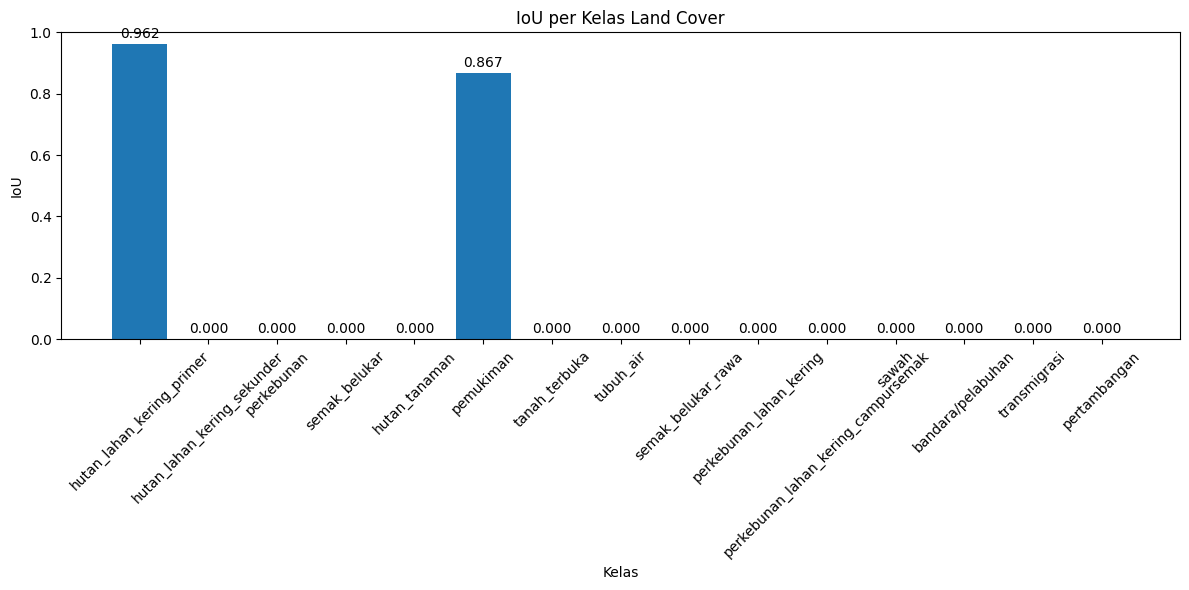

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


<ipython-input-34-6685c9e2d009>:187: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


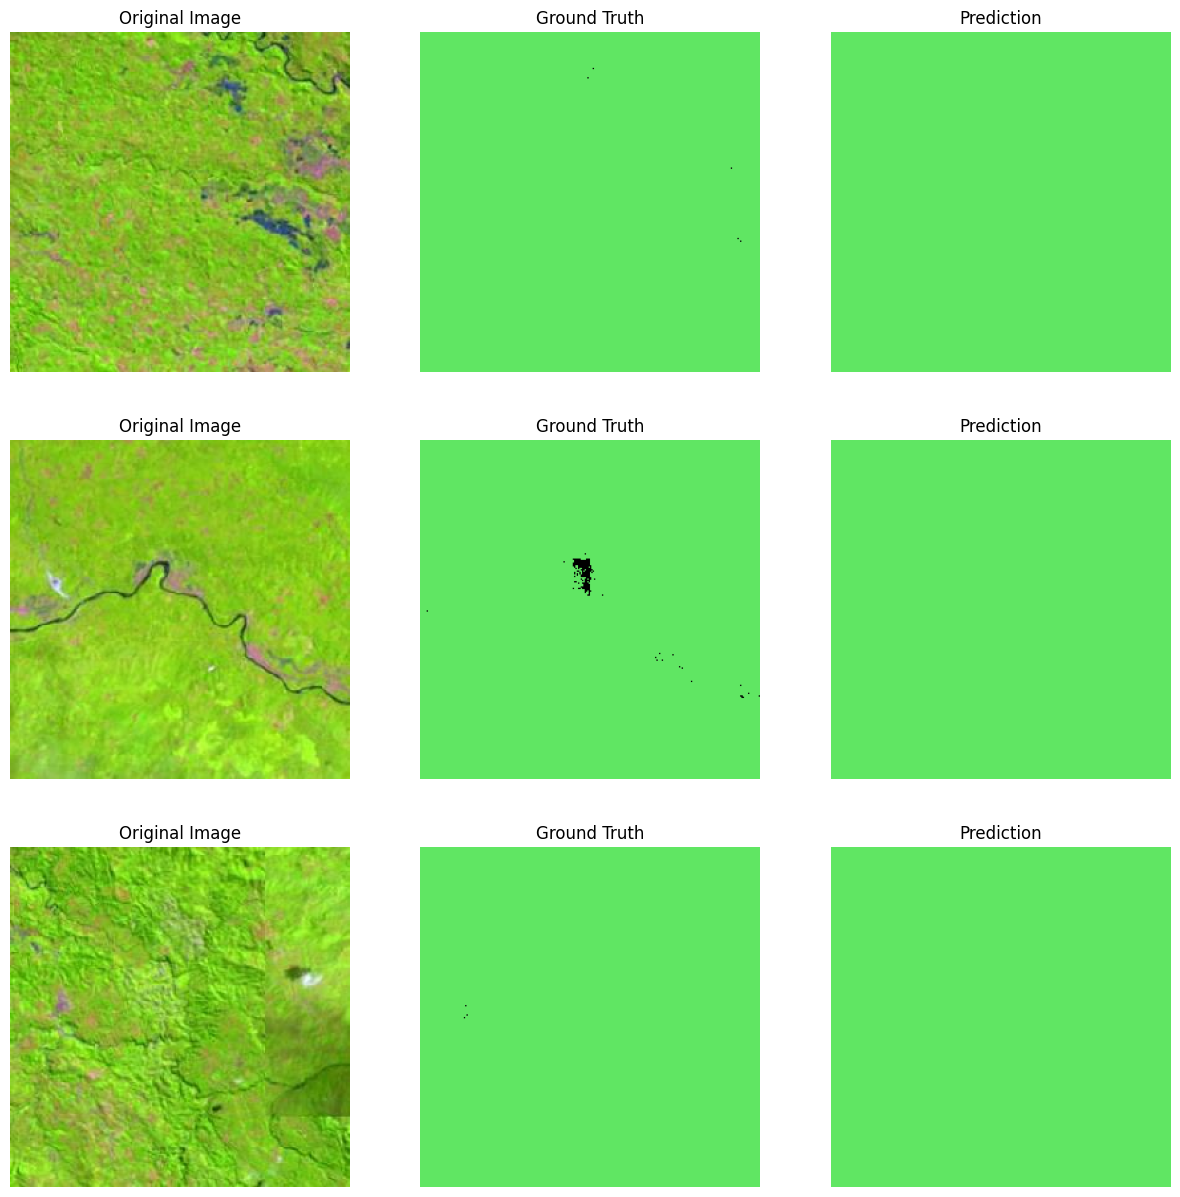

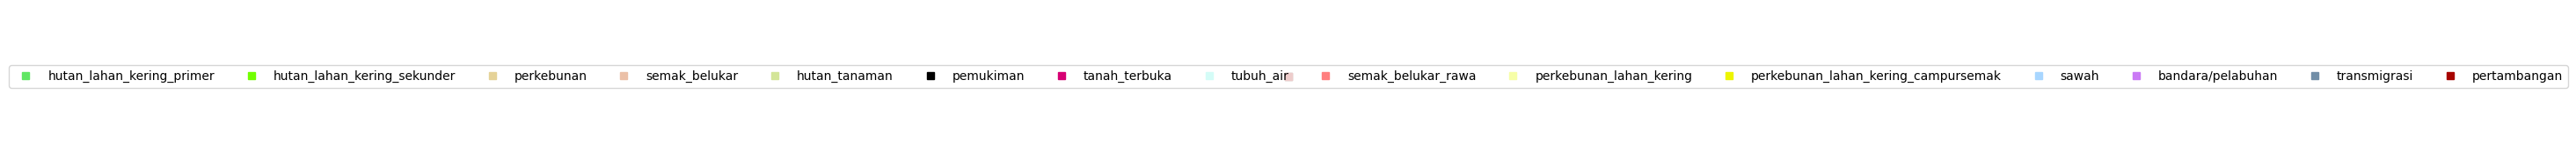

In [35]:
hasil = print_iou_results(model_loaded, X_valid, Y_valid)
visualize_predictions(model_loaded, X_valid, Y_valid, num_samples=3)


**Dice Coefficient**

In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def calculate_dice_metrics(model, x_data, y_data, num_classes=15):
    """
    Menghitung Dice Coefficient untuk model segmentasi

    Parameters:
        model: Model Keras yang sudah dilatih
        x_data: Data input gambar
        y_data: Data ground truth label (dengan format [..., 1])
        num_classes: Jumlah kelas dalam segmentasi

    Returns:
        Dictionary berisi mean_dice dan metrics per kelas
    """
    # Prediksi model
    y_pred = model.predict(x_data)

    # Mengonversi prediksi ke indeks kelas
    if len(y_pred.shape) == 4 and y_pred.shape[-1] > 1:
        y_pred = np.argmax(y_pred, axis=-1)

    # Mengonversi y_true ke format yang tepat
    y_true = np.squeeze(y_data)

    # Menghitung Dice per kelas secara manual
    class_dice = []
    class_names = ["hutan_lahan_kering_primer", "hutan_lahan_kering_sekunder", "perkebunan", "semak_belukar", "hutan_tanaman", "pemukiman", "tanah_terbuka", "tubuh_air", "semak_belukar_rawa", "perkebunan_lahan_kering", "perkebunan_lahan_kering_campursemak",
                   "sawah", "bandara/pelabuhan", "transmigrasi", "pertambangan"]

    for class_id in range(num_classes):
        true_class = (y_true == class_id).astype(np.int32)
        pred_class = (y_pred == class_id).astype(np.int32)

        # True Positive (TP)
        tp = np.sum(true_class * pred_class)
        # False Positive (FP)
        fp = np.sum(pred_class) - tp
        # False Negative (FN)
        fn = np.sum(true_class) - tp

        # Dice Coefficient = 2*TP / (2*TP + FP + FN)
        if 2*tp + fp + fn > 0:
            dice = 2*tp / (2*tp + fp + fn)
        else:
            dice = 0.0

        class_dice.append(dice)

    # Menghitung mean dice
    mean_dice = np.mean(class_dice)

    # Membuat hasil
    results = {
        "mean_dice": mean_dice,
        "class_dice": {class_names[i]: class_dice[i] for i in range(num_classes)},
        "class_dice_values": class_dice
    }

    return results

def print_dice_results(model, X_valid, Y_valid, num_classes=15):
    """
    Mencetak hasil evaluasi Dice Coefficient dengan format yang rapi
    """
    results = calculate_dice_metrics(model, X_valid, Y_valid, num_classes)

    print("=" * 60)
    print("HASIL EVALUASI DICE COEFFICIENT")
    print("=" * 60)
    print(f"Mean Dice Coefficient: {results['mean_dice']:.4f}")

    print("\nDice Coefficient per kelas:")
    print("-" * 60)
    print(f"{'Kelas':<15} {'Dice':<10}")
    print("-" * 60)

    for class_name in results['class_dice'].keys():
        dice = results['class_dice'][class_name]
        print(f"{class_name:<15} {dice:.4f}")

    # Analisis performa
    good_classes = [name for name, dice in results['class_dice'].items() if dice > 0.5]
    poor_classes = [name for name, dice in results['class_dice'].items() if dice < 0.3]

    print("\nAnalisis:")
    if good_classes:
        print(f"- Kelas dengan performa baik (Dice > 0.5): {', '.join(good_classes)}")
    if poor_classes:
        print(f"- Kelas dengan performa buruk (Dice < 0.3): {', '.join(poor_classes)}")

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.bar(results['class_dice'].keys(), results['class_dice'].values())
    plt.title('Dice Coefficient per Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Dice Coefficient')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(results['class_dice'].values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    print("=" * 60)

    return results

# Fungsi visualize_sample_predictions tetap sama
def visualize_sample_predictions(model, X_sample, Y_sample, num_samples=3, num_classes=15):
    """
    Visualisasi hasil prediksi model dibandingkan dengan ground truth
    """
    if num_samples > len(X_sample):
        num_samples = len(X_sample)

    colors = [
        (96, 230, 99),  # hutan_lahan_kering_primer
        (114, 255, 0),  # hutan_lahan_kering_sekunder
        (229, 210, 152),  # perkebunan
        (235, 192, 167),  # semak_belukar
        (211, 229, 152),  # hutan_tanaman
        (0, 0, 0),  # pemukiman
        (214, 0, 115),  # tanah_terbuka
        (212, 252, 247),  # tubuh_air
        (255, 127, 127),  # semak_belukar_rawa
        (246, 254, 167),  # pertanian_lahan_kering
        (237, 245, 0),  # pertanian_lahan_kering_campursemak
        (168, 214, 255),  # sawah
        (202, 122, 245),  # bandara/pelabuhan
        (114, 142, 167),  # transmigrasi
        (167, 4, 0)  # pertambangan
    ]

    class_names = ["hutan_lahan_kering_primer", "hutan_lahan_kering_sekunder", "perkebunan", "semak_belukar", "hutan_tanaman", "pemukiman", "tanah_terbuka", "tubuh_air", "semak_belukar_rawa", "perkebunan_lahan_kering", "perkebunan_lahan_kering_campursemak",
                   "sawah", "bandara/pelabuhan", "transmigrasi", "pertambangan"]

    if len(X_sample) > num_samples:
        indices = np.random.choice(len(X_sample), num_samples, replace=False)
        X_samples = X_sample[indices]
        Y_samples = Y_sample[indices]
    else:
        X_samples = X_sample[:num_samples]
        Y_samples = Y_sample[:num_samples]

    predictions = model.predict(X_samples)
    if len(predictions.shape) == 4 and predictions.shape[-1] > 1:
        predictions = np.argmax(predictions, axis=-1)

    ground_truth = np.squeeze(Y_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_samples[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        mask_vis = np.zeros((*ground_truth[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            mask_vis[ground_truth[i] == class_id] = color
        plt.imshow(mask_vis)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        pred_vis = np.zeros((*predictions[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            pred_vis[predictions[i] == class_id] = color
        plt.imshow(pred_vis)
        plt.title('Prediction')
        plt.axis('off')

    plt.figure(figsize=(12, 2))
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.plot(0, 0, 's', color=[c/255 for c in color], label=name)
    plt.legend(loc='center', ncol=len(class_names))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step 
HASIL EVALUASI DICE COEFFICIENT
Mean Dice Coefficient: 0.1273

Dice Coefficient per kelas:
------------------------------------------------------------
Kelas           Dice      
------------------------------------------------------------
hutan_lahan_kering_primer 0.9807
hutan_lahan_kering_sekunder 0.0000
perkebunan      0.0000
semak_belukar   0.0000
hutan_tanaman   0.0000
pemukiman       0.9286
tanah_terbuka   0.0000
tubuh_air       0.0000
semak_belukar_rawa 0.0000
perkebunan_lahan_kering 0.0000
perkebunan_lahan_kering_campursemak 0.0000
sawah           0.0000
bandara/pelabuhan 0.0000
transmigrasi    0.0000
pertambangan    0.0000

Analisis:
- Kelas dengan performa baik (Dice > 0.5): hutan_lahan_kering_primer, pemukiman
- Kelas dengan performa buruk (Dice < 0.3): hutan_lahan_kering_sekunder, perkebunan, semak_belukar, hutan_tanaman, tanah_terbuka, tubuh_air, semak_belukar_rawa, perkebunan_lahan_kering, perkebunan_lahan_kering_campursemak, sawah, 

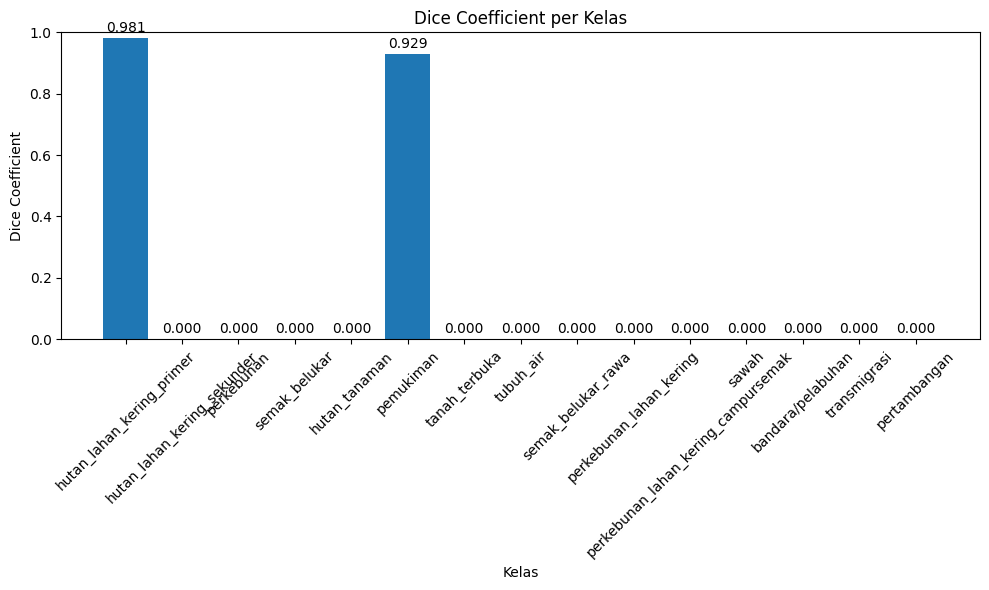

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


<ipython-input-32-da19c3dac7e4>:184: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


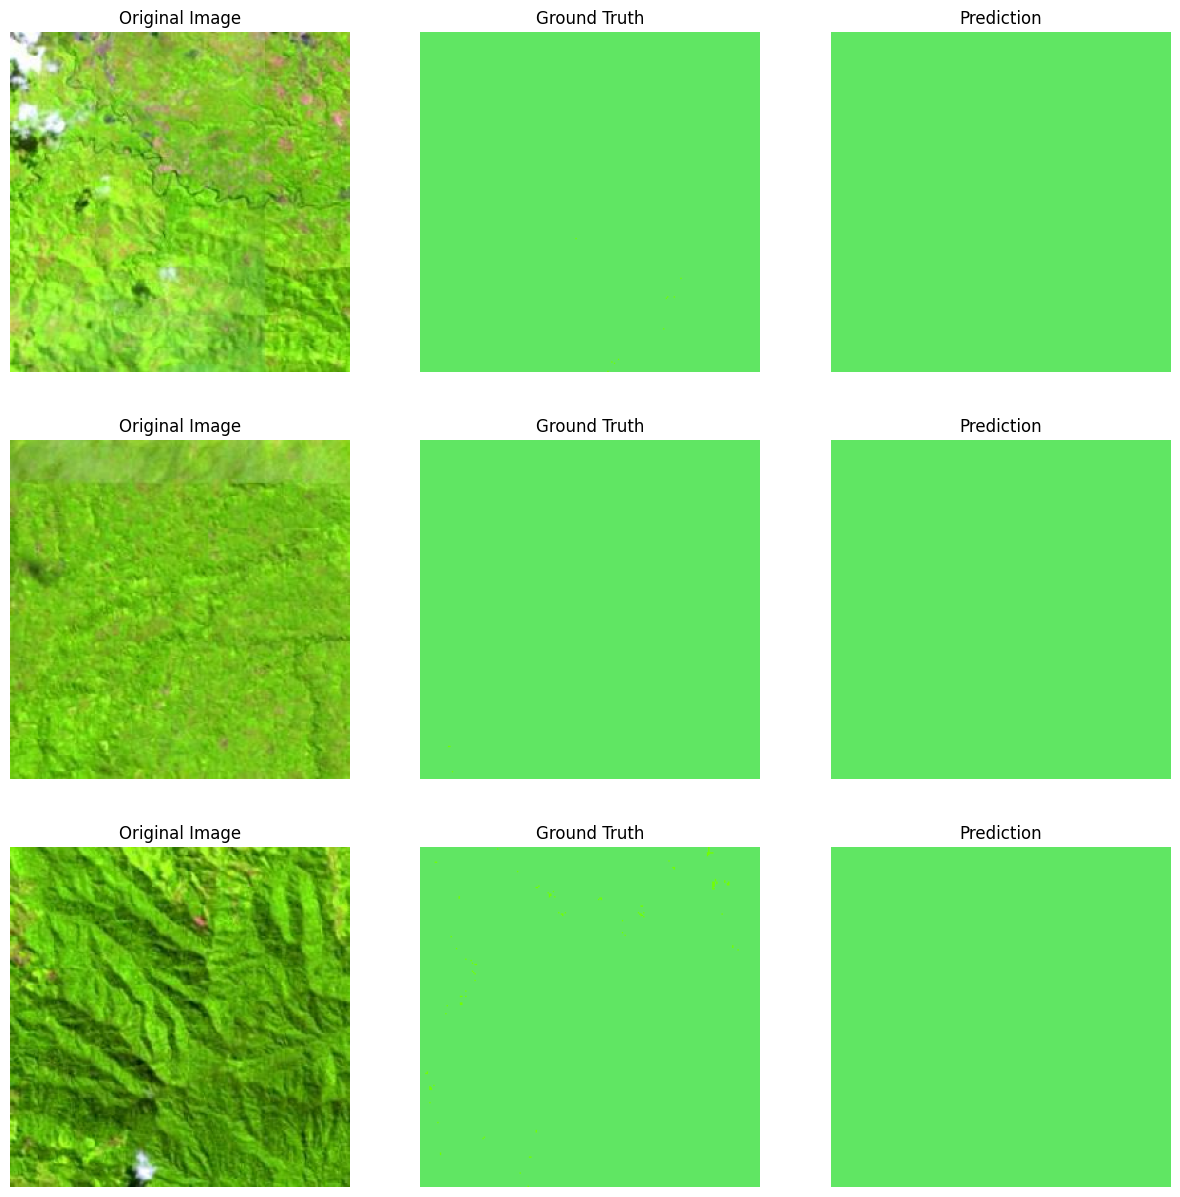

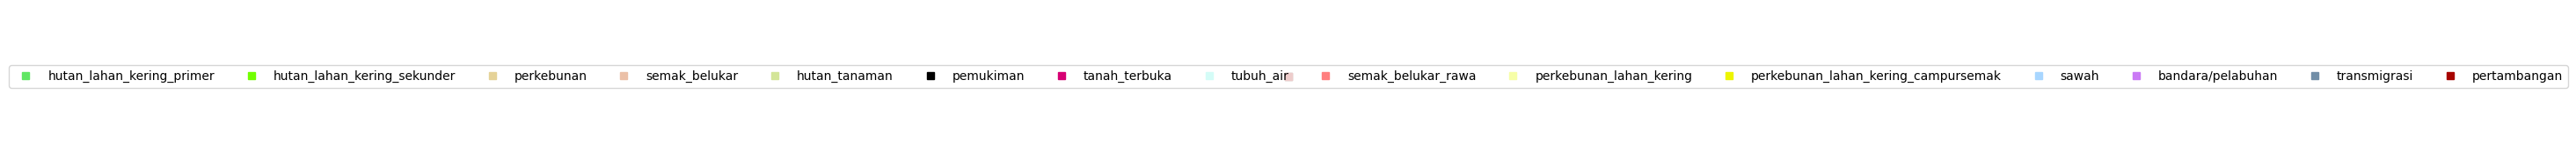

In [33]:
# Cara menggunakan:
hasil_dice = print_dice_results(model_loaded, X_valid, Y_valid)
visualize_sample_predictions(model_loaded, X_valid, Y_valid, num_samples=3)


**Pixel Accuracy**

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def calculate_pixel_accuracy(model, x_data, y_data, num_classes=15):
    """
    Menghitung Pixel Accuracy untuk model segmentasi

    Parameters:
        model: Model Keras yang sudah dilatih
        x_data: Data input gambar
        y_data: Data ground truth label (dengan format [..., 1])
        num_classes: Jumlah kelas dalam segmentasi

    Returns:
        Dictionary berisi overall_accuracy dan accuracy per kelas
    """
    # Prediksi model
    y_pred = model.predict(x_data)

    # Mengonversi prediksi ke indeks kelas
    if len(y_pred.shape) == 4 and y_pred.shape[-1] > 1:
        y_pred = np.argmax(y_pred, axis=-1)

    # Mengonversi y_true ke format yang tepat
    y_true = np.squeeze(y_data)

    # Menghitung overall pixel accuracy
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    overall_accuracy = correct_pixels / total_pixels

    # Menghitung accuracy per kelas
    class_accuracy = []
    class_names = ["hutan_lahan_kering_primer", "hutan_lahan_kering_sekunder", "perkebunan", "semak_belukar", "hutan_tanaman", "pemukiman", "tanah_terbuka", "tubuh_air", "semak_belukar_rawa", "perkebunan_lahan_kering", "perkebunan_lahan_kering_campursemak", "sawah", "bandara/pelabuhan", "transmigrasi", "pertambangan"]

    for class_id in range(num_classes):
        true_class = (y_true == class_id)
        pred_class = (y_pred == class_id)
        correct = np.sum(true_class & pred_class)
        total = np.sum(true_class)
        if total > 0:
            acc = correct / total
        else:
            acc = 0.0
        class_accuracy.append(acc)

    # Membuat hasil
    results = {
        "overall_accuracy": overall_accuracy,
        "class_accuracy": {class_names[i]: class_accuracy[i] for i in range(num_classes)},
        "class_accuracy_values": class_accuracy
    }

    return results

def print_accuracy_results(model, X_valid, Y_valid, num_classes=15):
    """
    Mencetak hasil evaluasi Pixel Accuracy dengan format yang rapi
    """
    results = calculate_pixel_accuracy(model, X_valid, Y_valid, num_classes)

    print("=" * 60)
    print("HASIL EVALUASI PIXEL ACCURACY")
    print("=" * 60)
    print(f"Overall Pixel Accuracy: {results['overall_accuracy']:.4f}")

    print("\nPixel Accuracy per kelas:")
    print("-" * 60)
    print(f"{'Kelas':<15} {'Accuracy':<10}")
    print("-" * 60)

    for class_name in results['class_accuracy'].keys():
        acc = results['class_accuracy'][class_name]
        print(f"{class_name:<15} {acc:.4f}")

    # Analisis performa
    good_classes = [name for name, acc in results['class_accuracy'].items() if acc > 0.7]
    poor_classes = [name for name, acc in results['class_accuracy'].items() if acc < 0.4]

    print("\nAnalisis:")
    if good_classes:
        print(f"- Kelas dengan performa baik (Accuracy > 0.7): {', '.join(good_classes)}")
    if poor_classes:
        print(f"- Kelas dengan performa buruk (Accuracy < 0.4): {', '.join(poor_classes)}")

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.bar(results['class_accuracy'].keys(), results['class_accuracy'].values())
    plt.title('Pixel Accuracy per Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(results['class_accuracy'].values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    print("=" * 60)

    return results

def visualize_sample_predictions(model, X_sample, Y_sample, num_samples=3, num_classes=15):
    """
    Visualisasi hasil prediksi model dibandingkan dengan ground truth
    """
    if num_samples > len(X_sample):
        num_samples = len(X_sample)

    colors = [
        (96, 230, 99),  # hutan_lahan_kering_primer
        (114, 255, 0),  # hutan_lahan_kering_sekunder
        (229, 210, 152),  # perkebunan
        (235, 192, 167),  # semak_belukar
        (211, 229, 152),  # hutan_tanaman
        (0, 0, 0),  # pemukiman
        (214, 0, 115),  # tanah_terbuka
        (212, 252, 247),  # tubuh_air
        (255, 127, 127),  # semak_belukar_rawa
        (246, 254, 167),  # pertanian_lahan_kering
        (237, 245, 0),  # pertanian_lahan_kering_campursemak
        (168, 214, 255),  # sawah
        (202, 122, 245),  # bandara/pelabuhan
        (114, 142, 167),  # transmigrasi
        (167, 4, 0)  # pertambangan
    ]

    class_names = ["hutan_lahan_kering_primer", "hutan_lahan_kering_sekunder", "perkebunan", "semak_belukar", "hutan_tanaman", "pemukiman", "tanah_terbuka", "tubuh_air", "semak_belukar_rawa", "perkebunan_lahan_kering", "perkebunan_lahan_kering_campursemak", "sawah", "bandara/pelabuhan", "transmigrasi", "pertambangan"]

    if len(X_sample) > num_samples:
        indices = np.random.choice(len(X_sample), num_samples, replace=False)
        X_samples = X_sample[indices]
        Y_samples = Y_sample[indices]
    else:
        X_samples = X_sample[:num_samples]
        Y_samples = Y_sample[:num_samples]

    predictions = model.predict(X_samples)
    if len(predictions.shape) == 4 and predictions.shape[-1] > 1:
        predictions = np.argmax(predictions, axis=-1)

    ground_truth = np.squeeze(Y_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_samples[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        mask_vis = np.zeros((*ground_truth[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            mask_vis[ground_truth[i] == class_id] = color
        plt.imshow(mask_vis)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        pred_vis = np.zeros((*predictions[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            pred_vis[predictions[i] == class_id] = color
        plt.imshow(pred_vis)
        plt.title('Prediction')
        plt.axis('off')

    plt.figure(figsize=(12, 2))
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.plot(0, 0, 's', color=[c/255 for c in color], label=name)
    plt.legend(loc='center', ncol=len(class_names))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step 
HASIL EVALUASI PIXEL ACCURACY
Overall Pixel Accuracy: 0.9695

Pixel Accuracy per kelas:
------------------------------------------------------------
Kelas           Accuracy  
------------------------------------------------------------
hutan_lahan_kering_primer 0.9813
hutan_lahan_kering_sekunder 0.0000
perkebunan      0.0000
semak_belukar   0.0000
hutan_tanaman   0.0000
pemukiman       0.9279
tanah_terbuka   0.0000
tubuh_air       0.0000
semak_belukar_rawa 0.0000
perkebunan_lahan_kering 0.0000
perkebunan_lahan_kering_campursemak 0.0000
sawah           0.0000
bandara/pelabuhan 0.0000
transmigrasi    0.0000
pertambangan    0.0000

Analisis:
- Kelas dengan performa baik (Accuracy > 0.7): hutan_lahan_kering_primer, pemukiman
- Kelas dengan performa buruk (Accuracy < 0.4): hutan_lahan_kering_sekunder, perkebunan, semak_belukar, hutan_tanaman, tanah_terbuka, tubuh_air, semak_belukar_rawa, perkebunan_lahan_kering, perkebunan_lahan_kering_campursemak, sa

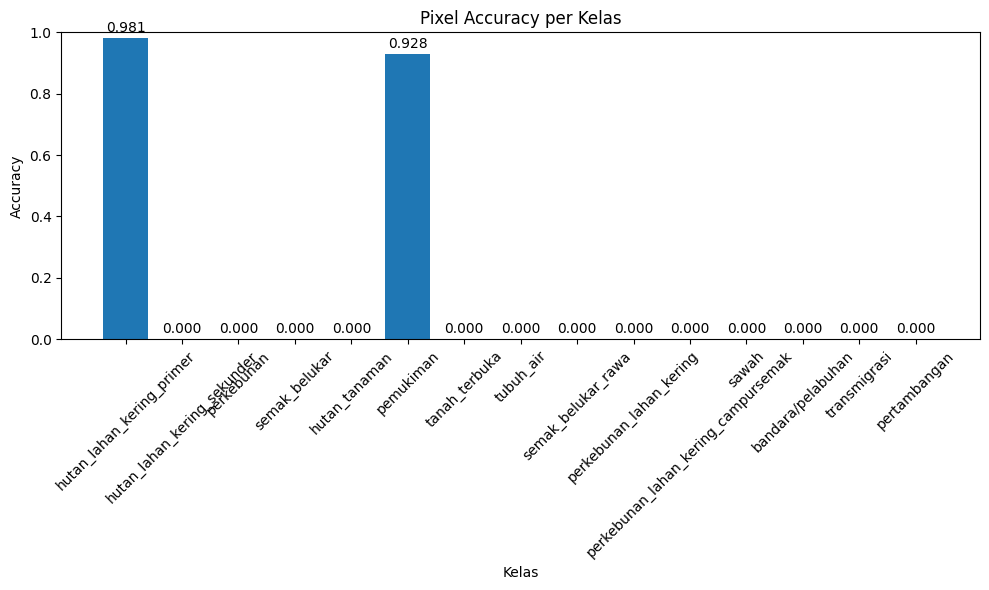

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


<ipython-input-30-b0c1f569e14f>:175: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


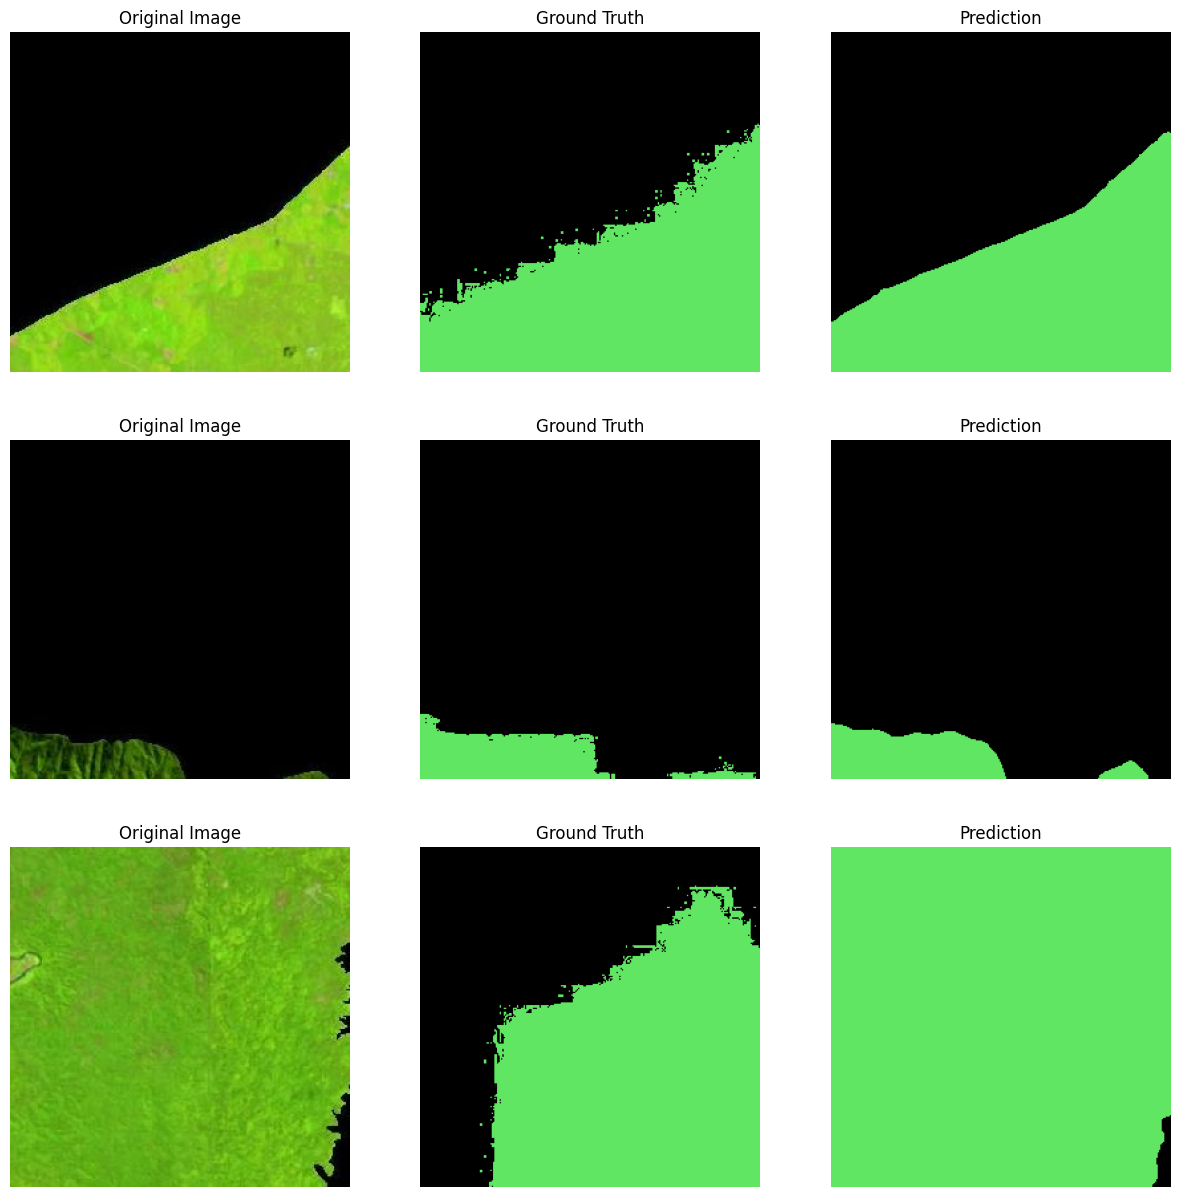

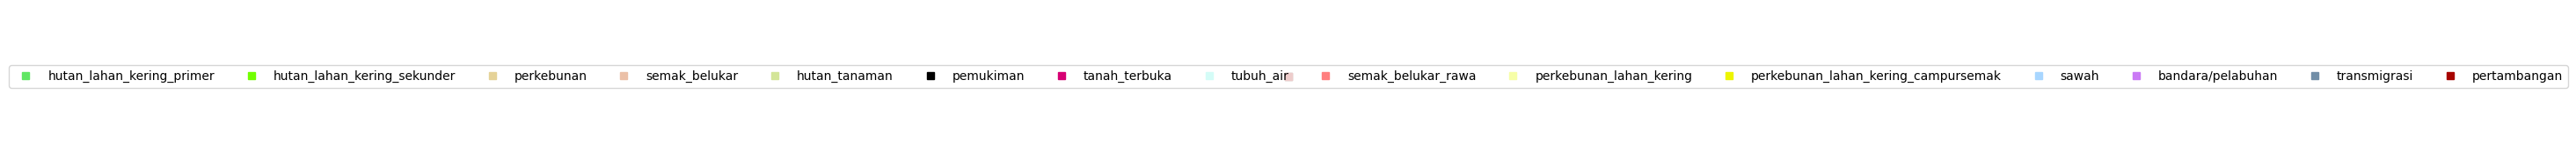

In [31]:
hasil_pixel = print_accuracy_results(model_loaded, X_valid, Y_valid)
visualize_sample_predictions(model_loaded, X_valid, Y_valid, num_samples=3)
